In [1]:
import numpy as np
import pandas as pd
import physutils as phys
import physutils.bootstrap as boot
import physutils.tf as tf
import matplotlib.pyplot as plt
import dbio

%matplotlib inline
np.random.seed(12346)

In [2]:
from time_frequency_helpers import *

In [3]:
import scipy.signal as ssig
import itertools

import seaborn as sns

/home/pearson/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# data location
dbname = 'data/bart.hdf5'

# get list of (patient, dataset) tuples to plot
dsets = pd.read_csv('data/lfp_channel_file.csv', header=None).iloc[:, :2].drop_duplicates()

In [5]:
dtup = 18, 1

In [6]:
lfp = load_and_preprocess(dbname, dtup)

In [7]:
dt = 1/200.
epoch_dict = {}
epoch_dict['starts'] = (0., 0.5)
epoch_dict['stops'] = (-0.5, 0.)
epoch_dict['pops'] = (-0.5, 0.)

In [8]:
evt = dbio.fetch(dbname, 'events', *dtup)
evtdict = {}
evtdict['stops'] = evt['banked'].dropna()
evtdict['pops'] = evt['popped'].dropna()
evtdict['starts'] = evt['start inflating']
if 'is_control' in evt.columns:
    evtdict['stops_free'] = evt.query('is_control == False')['banked'].dropna()
    evtdict['stops_control'] = evt.query('is_control == True')['banked'].dropna()
    evtdict['stops_rewarded'] = evt.query('trial_type != 4')['banked'].dropna()
    evtdict['stops_unrewarded'] = evt.query('trial_type == 4')['banked'].dropna()
else:
    evtdict['stops_free'] = evtdict['stops']
    evtdict['stops_control'] = None
    evtdict['stops_rewarded'] = evtdict['stops']
    evtdict['stops_unrewarded'] = None

In [9]:
evtdict.keys()

['stops_control',
 'starts',
 'stops_free',
 'stops_unrewarded',
 'stops',
 'pops',
 'stops_rewarded']

In [10]:
def calc_coh(df, pair, nT):
    faxis, coh = ssig.coherence(df[pair[0]], df[pair[1]], fs=200.0, 
                   window='hanning', nperseg=nT, noverlap=None, 
                   nfft=None, detrend='constant', axis=-1)
    return pd.DataFrame(coh, index=faxis)

In [11]:
def get_coh_all_pairs(lfp, nT):
    chanpairs_list = []
    for pair in itertools.combinations(lfp.columns, 2):
        coh = calc_coh(lfp, pair, nT)
        coh.columns = [pair]
        chanpairs_list.append(coh)
    return pd.concat(chanpairs_list, axis=1)

In [12]:
events = ['starts', 'stops', 'pops']

coh_list = []
ev_list = []
for evtype in events:
    Tpre, Tpost = epoch_dict[evtype]
    
    nT = np.around((Tpost - Tpre)/dt).astype('int')
    
    # get chunks around each event
    lfp_split = lfp.evtsplit(evtdict[evtype], Tpre, Tpost)
    
    # get rid of all chunks containing nans
    lfp_list = [d for _, d in lfp_split.groupby(level=0) if not np.any(np.isnan(d.values))]
    
    # concatenate vertically back into dataframe
    if lfp_list:
        this_lfp = pd.concat(lfp_list)
        ev_list.append(evtype)
    else:
        continue
    
    # get coherence for all pairs of channels
    coh = get_coh_all_pairs(this_lfp, nT)

    # add coherence to list in tidy form
    coh_list.append(coh.stack())
    
# concatenate data horizontally; make frequency a column    
df = pd.concat(coh_list, axis=1).reset_index()
df.columns = ["freq", "pair"] + ev_list

# make data tidy for plotting
df = pd.melt(df, id_vars=["freq", "pair"])

In [13]:
df.head()

,freq,pair,variable,value
0,0,"(17, 18)",starts,0.563884
1,0,"(17, 19)",starts,0.866273
2,0,"(17, 20)",starts,0.368267
3,0,"(17, 21)",starts,0.003656
4,0,"(17, 22)",starts,0.143239


/home/pearson/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


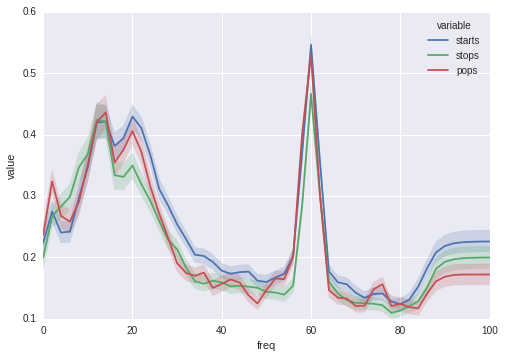

In [14]:
sns.tsplot(data=df, time="freq", unit="pair",
           condition="variable", value="value",
           ci=95)